# Distance diagnostics

In [1]:
import numpy as np
import pandas as pd
import xarray as xr

import dask.dataframe as dd
import os
from glob import glob

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.geodesic as cgeo

import matplotlib.transforms as mtransforms
crs = ccrs.PlateCarree()

import histlib.matchup as match
from  histlib.diagnosis import build_matchup_dataframe, synthetic_figure, path_csv, put_fig_letter, build_diagnostic
from histlib.cstes import labels, zarr_dir, matchup_dir, c0, U
U2=U**2

/home1/datahome/mdemol/.miniconda3/envs/histenv2/lib/python3.9/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.scheduler.transition-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(
/home1/datahome/mdemol/.miniconda3/envs/histenv2/lib/python3.9/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.comm.recent-messages-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(


__________
___________
# Compute mean

In [2]:
comb_av_d = {'acc':'drifter_acc_x_25', 'cor':'drifter_coriolis_x_25', 'ggx':'aviso_drifter_ggx_adt', 'wd':'es_cstrio_z15_drifter_wd_x'}
comb_av_al = {'acc':'drifter_acc_x_25', 'cor':'drifter_coriolis_x_25', 'ggx':'aviso_alti_ggx_adt', 'wd':'es_cstrio_z15_drifter_wd_x'}
comb_alg = {'acc':'drifter_acc_x_25','cor':'drifter_coriolis_x_25','ggx':'alti_ggx_adt_filtered_ocean_tide_internal_tide','wd':'es_cstrio_z15_drifter_wd_x'}


dad = pd.read_csv(os.path.join(zarr_dir,'analysis_files', 'dist_mean___'+'__'.join([comb_av_d[key] for key in comb_av_d])+'.csv')).set_index('distbin').to_xarray()
daa = pd.read_csv(os.path.join(zarr_dir,'analysis_files', 'dist_mean___'+'__'.join([comb_av_al[key] for key in comb_av_al])+'.csv')).set_index('distbin').to_xarray()
dl = pd.read_csv(os.path.join(zarr_dir,'analysis_files', 'dist_mean___'+'__'.join([comb_alg[key] for key in comb_alg])+'.csv')).set_index('distbin').to_xarray()

def center_distbin(df) :
    dl = df.distbin.diff('distbin').mean()/1e3
    df['distbin'] = df['distbin']/1e3+dl/2
    return df

dad = center_distbin(dad)/U2
daa = center_distbin(daa)/U2
dl = center_distbin(dl)/U2

In [3]:
dl

<xarray.Dataset>
Dimensions:          (distbin: 100)
Coordinates:
  * distbin          (distbin) float64 1.0 3.0 5.0 7.0 ... 195.0 197.0 199.0
Data variables: (12/41)
    B_acc            (distbin) float64 0.8473 0.8251 0.8402 ... 0.7007 0.6572
    E_cor            (distbin) float64 0.5717 0.4518 0.5596 ... 2.405 2.753
    B_cor            (distbin) float64 3.441 3.333 3.327 ... 1.346 1.357 1.28
    E_ggx            (distbin) float64 0.5312 0.6017 0.6606 ... 2.931 2.854 2.85
    B_ggx            (distbin) float64 2.765 2.735 2.788 ... 0.501 0.5347 0.4431
    E_wd             (distbin) float64 0.02761 0.02787 ... 0.03235 0.02428
    ...               ...
    be__ACC          (distbin) float64 0.0268 0.01752 ... 0.02486 0.02359
    be__COR          (distbin) float64 0.1168 0.07337 ... 0.07864 0.09155
    be__GGX          (distbin) float64 0.09967 0.07356 ... 0.08612 0.08227
    be__WD           (distbin) float64 0.006844 0.004419 ... 0.004721 0.005195
    be__S            (distbin) float64 0.03474 0.02261 0.04517 ... 0.1165 0.149
    be__sigma        (distbin) float64 0.2159 0.1431 0.1551 ... 0.1351 0.1391

In [4]:
def exp_decay(dx, dx_constant, amplitude, cst):
    return np.exp(-dx / dx_constant)*amplitude +cst

fit_cor_alg = dl.X_acc_ggx.curvefit("distbin", exp_decay)
fit_acc_alg = dl.X_cor_ggx.curvefit("distbin", exp_decay)
fit_cor_av = daa.X_acc_ggx.curvefit("distbin", exp_decay)
fit_acc_av = daa.X_acc_ggx.curvefit("distbin", exp_decay)
#fit_cor_wd_alti = cor_wd_alti.curvefit("distbin", exp_decay)

KeyError: 'ggrad'

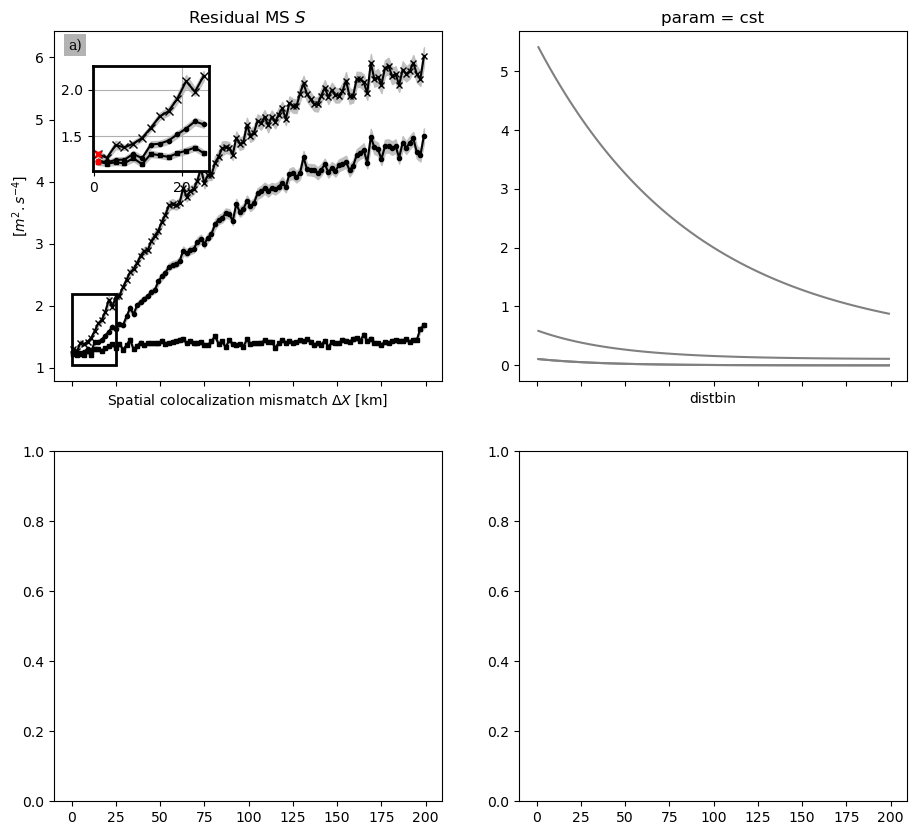

In [5]:
def plot_error(df, v, ax):
    ax.fill_between(df.distbin, df[v]-df['be__'+v], df[v]+df['be__'+v], color='silver')

fig, axs = plt.subplots(2, 2, sharex=True, figsize=(11,10), frameon=False)
axs =axs.flatten()

# plot param 
m =3 #markersize
a=0.7
ins_ax_box = [0.1,0.60,0.3,0.3]#[x0,y0,xlen, ylen]
import matplotlib.patches as patches

ax =axs[0]
dl.S.plot(label='Along-track', ax=ax, c='k', marker='x', markeredgewidth = 1, markersize=m+1)
daa.S.plot(label='altimeter-matchup-AVISO', ax=ax, c='k', marker='o', markersize=m)
dad.S.plot(label='AVISO', ax=ax, c='k', marker='s', markersize=m,)
#born_co.plot(ax=ax, color='k', ls = 'dashed')
#born_aviso.plot(ax=ax,color='k', ls = ':')
plot_error(dl, 'S', ax)
plot_error(daa, 'S', ax)
plot_error(dad, 'S', ax)

ax.set_xlabel('Spatial colocalization mismatch $\Delta X$ [km]')
ax.set_ylabel(r"$[m^2.s^{-4}]$")
ax.set_title(r'Residual MS $S$')
put_fig_letter(fig, ax, 'a')
handles0, labels0 = ax.get_legend_handles_labels()

#ZOOM
rect = patches.Rectangle((0, 1e-10/U2), 25, 1.1e-10/U2, linewidth=2, edgecolor='k', facecolor='none')
ax.add_patch(rect)
ins = ax.inset_axes(ins_ax_box)
dl.sel(distbin=slice(0, 25)).S.plot(label='Along-track', ax=ins, c='k', marker='x')
daa.sel(distbin=slice(0, 25)).S.plot(label='altimeter-matchup-AVISO', ax=ins, c='k', marker='o', markersize=m)
dad.sel(distbin=slice(0, 25)).S.plot(label='AVISO', ax=ins, c='k', marker='s', markersize=m,)
plot_error(dl.sel(distbin=slice(0, 25)), 'S', ins)
plot_error(daa.sel(distbin=slice(0, 25)), 'S', ins)
plot_error(dad.sel(distbin=slice(0, 25)), 'S', ins)
ins.plot(dl.S.isel(distbin=0).distbin, dl.S.isel(distbin=0), color='r', marker='x', markeredgewidth = 2,markersize=m+1)
ins.plot(daa.S.isel(distbin=0).distbin,daa.S.isel(distbin=0), color='r', marker='o', markersize=m)
ins.plot(dad.S.isel(distbin=0).distbin, dad.S.isel(distbin=0), color='r', marker='s', markersize=m,)

ins.grid()
ins.spines['bottom'].set_color('k')
ins.spines['top'].set_color('k')
ins.spines['left'].set_color('k')
ins.spines['right'].set_color('k')
ins.spines['bottom'].set_linewidth(2)
ins.spines['top'].set_linewidth(2)
ins.spines['left'].set_linewidth(2)
ins.spines['right'].set_linewidth(2)
ins.set_xlabel('')
ins.set_ylabel('')
#ins.set_ylim(1e-10, 2.1e-10)
#ax.annotate('',xy=(12.5,2.1e-10),xytext=(25,4.25e-10),arrowprops={'arrowstyle':'-', 'color':'k', 'linewidth':2})

ax =axs[1]

exp_decay(dl.distbin, *fit_cor_alg.curvefit_coefficients).plot(c='grey', label = 'Exponential decay fit', ax=ax)
exp_decay(dl.distbin, *fit_acc_alg.curvefit_coefficients).plot(c='grey', ax=ax)
exp_decay(daa.distbin, *fit_cor_av.curvefit_coefficients).plot( c='grey', ax=ax)
exp_decay(daa.distbin, *fit_acc_av.curvefit_coefficients).plot( c='grey', ax=ax)
dl.X_cor_ggx.plot(c = c0['ggrad'], marker = 'x', markeredgewidth = 1, markeredgecolor=c0['coriolis'],markersize=m+1, lw=2, ax=ax)#,label= 'Coriolis acceleration - Pressure gradient estimated from along-track altimetry')
dl.X_acc_ggx.plot(c = c0['ggrad'], marker = 'x', markeredgewidth = 1, markeredgecolor=c0['acc'],markersize=m+1, ax=ax)#, label= 'Inertial acceleration - Pressure gradient estimated from along-track altimetry')
daa.X_cor_ggx.plot(c = c0['ggrad'], marker = 'o', markerfacecolor=c0['coriolis'], markersize=m, lw=2, ax=ax)#, label= 'Coriolis acceleration - Pressure gradient estimated from AVISO altimetry at along-track matchup')
daa.X_acc_ggx.plot(c = c0['ggrad'], marker = 'o', markerfacecolor=c0['acc'], markersize=m, lw=2, ax=ax)#, label= 'Inertial acceleration - Pressure gradient estimated from AVISO altimetry at along-track matchup')
plot_error(dl, 'X_cor_ggx', ax)
plot_error(dl, 'X_acc_ggx', ax)
plot_error(daa, 'X_cor_ggx', ax)
plot_error(daa, 'X_acc_ggx', ax)

put_fig_letter(fig, ax, 'b')
handles_exp, labels_exp = ax.get_legend_handles_labels()


ax.set_xlabel('Spatial colocalization mismatch $\Delta X$ [km]')
ax.set_ylabel(r"$[m^2.s^{-4}]$")
ax.set_title(r"Pairs' contribution $X_{ij}$")
handles1, labels1 = ax.get_legend_handles_labels()

ax.annotate('Coriolis acceleration-Pressure gradient term', xy=(100, 2e-10/U2), xytext=(50, 4e-10/U2),
            arrowprops=dict(arrowstyle="->"))
ax.annotate('Inertial acceleration-Pressure gradient term', xy=(100, 0.2e-10/U2), xytext=(3, 0.8e-10/U2),
            arrowprops=dict(arrowstyle="->"))
ax = axs[2]

for v in ['cor', 'ggx', 'wd']:
    dl['E_'+v].plot(label='Along Track ' +v, color = c0[v], marker='x',markeredgewidth = 2,markersize=m+1, ax=ax)
    daa['E_'+v].plot(label='AVISO ' +v, color = c0[v], marker='o',markersize=m, ax=ax)
    if v=='ggx' : 
        ax.axhline(dl['E_'+v][v].mean(), color = c0[v],  ls='--', alpha=a)
        ax.axhline(daa['E_'+v][v].mean(), color = c0[v],  ls=':', alpha=a)
#ax.legend(ncol = 2, bbox_to_anchor=(0, -0.7), loc='lower left')
ax.set_xlim(0,200)
ax.set_ylim(-0.2e-10,3.8e-10)
ax.set_xlabel('Spatial colocalization mismatch $\Delta X$ [km]')
ax.set_ylabel(r"$[m^2.s^{-4}]$")
ax.set_title(r'Errors parts $E_i$')
put_fig_letter(fig, ax, 'c')

"""
ax=axs[3]

for v in ['acc', 'coriolis', 'ggrad', 'wind']:
    dsdt.sel(id_comb=id_co)['true_'+v].plot(label='Along Track ' +v, color = c0[v], marker='x',markeredgewidth = 2,markersize=m+1, ax=ax)
    dsdt.sel(id_comb=id_aviso)['true_'+v].plot(label='AVISO ' +v, color = c0[v], marker='o',markersize=m, ax=ax)
    
#ax.legend(ncol = 2, bbox_to_anchor=(0, -0.7), loc='lower left')
ax.set_xlim(0,200)
ax.set_ylim(-0.2e-10,3.8e-10)
ax.set_xlabel('Spatial colocalization mismatch $\Delta X$ [km]')
ax.set_ylabel(r"$[m^2.s^{-4}]$")
ax.set_title(r'Balanced parts $B_i$')

put_fig_letter(ax, 'd')


for ax in axs :
    ax.grid()
handles, labels = handles_+handles0+handles_dummy+handles__+2*handles_dummy+handles_exp+3*handles_dummy, labels_+labels0+labels_dummy+labels__+2*labels_dummy+labels_exp+3*labels_dummy
fig.legend(handles, labels, ncols=4,loc='lower center')
fig.tight_layout(rect=[0,0.09,1,1])#left, bottom, right, top (default is 0,0,1,1)

fig.savefig('../images_all/dist_total.png',bbox_inches='tight',   dpi=300)

"""